<a href="https://colab.research.google.com/github/Sureshkasira/sureshkasira/blob/main/SIP_Investment_Growth_Analysis_Final_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests beautifulsoup4

In [ ]:
pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
pip install pandas

**FINAL Script for Mutual Fund Analysis on SIP**

In [ ]:
from datetime import datetime, timedelta, date
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

# Configuration
scheme_name = "HDFC Mid-Cap" #Change the MF name as well as in the URL based on your investment name.
sip_amount = 1000 #Adjust the SIP amount as you want
start_sip_date = date(2024, 7, 11)  # Starting SIP date from August 11, 2024
today_date = datetime.now().date()  # Current date

# Define start and end dates for the NAV URL
start_date = start_sip_date.strftime("%d-%m-%Y")
end_date = (datetime.now() - timedelta(days=1)).strftime("%d-%m-%Y")

# Format URL for fetching NAV history
url = f"https://www.advisorkhoj.com/mutual-funds-research/historical-NAV/HDFC%20Mid-Cap%20Opportunities%20Gr?start_date={start_date}&end_date={end_date}"

# Fetch and parse NAV data from Advisorkhoj
def get_nav_history():
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    rows = soup.find_all("tr")

    nav_history = {}
    for row in rows[1:]:  # Skip header row
        cols = row.find_all("td")
        if len(cols) == 2:
            nav_date = datetime.strptime(cols[0].text.strip(), "%d-%m-%Y").date()
            nav_value = float(cols[1].text.strip())
            nav_history[nav_date] = nav_value
    return nav_history

# Get the NAV history data
nav_history = get_nav_history()

# Placeholder function to get NAV on a specific SIP date
def get_nav_on_date(sip_date):
    return nav_history.get(sip_date, None)  # Return NAV if date exists in history

# Fetch the latest NAV and its date
def get_latest_nav():
    if nav_history:
        latest_date = max(nav_history.keys())
        latest_nav = nav_history[latest_date]
        return latest_nav, latest_date
    return None, None

# Function to get next business day
def next_business_day(sip_date):
    while sip_date.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        sip_date += timedelta(days=1)
    return sip_date

# Create SIP entries for the 11th of each month from start date to today
sip_dates = pd.date_range(start=start_sip_date, end=today_date, freq='MS').to_list()
sip_dates = [date(sip_date.year, sip_date.month, 11) for sip_date in sip_dates]  # Change to the 11th

# Adjust SIP dates to the next business day if they fall on a weekend
sip_dates = [next_business_day(sip_date) for sip_date in sip_dates]

# Append current month if today is after the 11th
if today_date.day > 11:
    current_sip_date = today_date
    if today_date.weekday() >= 5:  # Check if today is Sat/Sun
        current_sip_date = today_date - timedelta(days=today_date.weekday() - 4)  # Get last Friday
    sip_dates.append(current_sip_date)

sip_data = []

for sip_date in sip_dates:
    nav_on_sip_date = get_nav_on_date(sip_date)
    if nav_on_sip_date is not None:
        units_assigned = sip_amount / nav_on_sip_date  # Calculate units based on NAV at SIP date

        # Fetch the most recent NAV and date
        current_nav, current_date = get_latest_nav()

        # Calculate the market value based on the most recent NAV
        market_value = units_assigned * current_nav if current_nav else None

        # Append row data for the SIP
        sip_data.append({
            "Scheme Name": scheme_name,
            "SIP Amount": sip_amount,
            "SIP Date": sip_date,
            "Units": f"{units_assigned:.2f}",  # Format to 2 decimal places
            "NAV on SIP Date": nav_on_sip_date,
            "Current NAV": current_nav,
            "Current Date": current_date,
            "Market Value": f"{market_value:.2f}" #if market_value else None,  # Format Market Value to two decimals
        })

# Create a DataFrame for easy viewing and analysis
sip_df = pd.DataFrame(sip_data)

# Calculate the total market value
sip_df['Market Value'] = sip_df['Market Value'].astype(float)  # Ensure the column is float
total_market_value = sip_df['Market Value'].sum()


# Calculate the total investment value
total_invest_value = sip_df['SIP Amount'].astype(float).sum()

# Add total market value and total investment value as new columns in the DataFrame
#sip_df['Total Market Value'] = total_market_value
sip_df['Total Market Value'] = f"{total_market_value:.2f}" # Format Market Value to two decimals
sip_df['Total Invest Value'] = total_invest_value

# Calculate percentage of returns and add as a new column
sip_df['Returns (%)'] = ((sip_df['Total Market Value'].astype(float) -
                                   sip_df['Total Invest Value'].astype(float)) /
                                  sip_df['Total Invest Value'].astype(float)) * 100

# Format the Returns column to 2 decimal places
sip_df['Returns (%)'] = sip_df['Returns (%)'].apply(lambda x: f"{x:.2f}")

# Calculate Profit/Loss of Amount on Investement and add as a new column
sip_df['Profit/Loss'] = (sip_df['Total Market Value'].astype(float) -
                                   sip_df['Total Invest Value'].astype(float))
# Format the ReProfit/Loss  column to 2 decimal places
sip_df['Profit/Loss'] = sip_df['Profit/Loss'].apply(lambda x: f"{x:.2f}")

# Print total summary of Profit & Loss at the Top of the Output
print(f"Total Market Value: ₹{total_market_value:.2f}")

print(f"Total Invest Value: ₹{total_invest_value:.2f}")

gain_loss = (total_market_value - total_invest_value)
print(f"Gain/Loss: ₹{gain_loss:.2f}")

overall_return_percentage = ((total_market_value - total_invest_value) / total_invest_value) * 100
print(f"Overall Return (%): {overall_return_percentage:.2f}%")


# Display the SIP DataFrame in a clean format
pd.set_option('display.float_format', '₹{:,.2f}'.format)  # Format floats as currency
print(tabulate(sip_df, headers='keys', tablefmt='pretty'))

Total Market Value: ₹2965.97
Total Invest Value: ₹3000.00
Gain/Loss: ₹-34.03
Overall Return (%): -1.13%
+---+--------------+------------+------------+-------+-----------------+-------------+--------------+--------------+--------------------+--------------------+-------------+-------------+
|   | Scheme Name  | SIP Amount |  SIP Date  | Units | NAV on SIP Date | Current NAV | Current Date | Market Value | Total Market Value | Total Invest Value | Returns (%) | Profit/Loss |
+---+--------------+------------+------------+-------+-----------------+-------------+--------------+--------------+--------------------+--------------------+-------------+-------------+
| 0 | HDFC Mid-Cap |    1000    | 2024-08-12 | 5.44  |     183.751     |   186.322   |  2024-10-29  |   1013.99    |      2965.97       |       3000.0       |    -1.13    |   -34.03    |
| 1 | HDFC Mid-Cap |    1000    | 2024-09-11 | 5.25  |     190.612     |   186.322   |  2024-10-29  |    977.49    |      2965.97       |       3000

In [ ]:
import pandas as pd

# Save the DataFrame as an Excel file
sip_df.to_excel("sip_investment_growth.xlsx", index=False)

print("Data has been saved to 'sip_investment_growth.xlsx'")

Data has been saved to 'sip_investment_growth.xlsx'


In [ ]:
from tabulate import tabulate
import pandas as pd
# Read the Excel file
sip_df = pd.read_excel("sip_investment_growth.xlsx")

# Print the contents of the Excel file
#print(sip_df)
print(tabulate(sip_df, headers='keys', tablefmt='pretty'))

+---+--------------+------------+---------------------+-------+-----------------+-------------+---------------------+--------------+--------------------+--------------------+-------------+-------------+
|   | Scheme Name  | SIP Amount |      SIP Date       | Units | NAV on SIP Date | Current NAV |    Current Date     | Market Value | Total Market Value | Total Invest Value | Returns (%) | Profit/Loss |
+---+--------------+------------+---------------------+-------+-----------------+-------------+---------------------+--------------+--------------------+--------------------+-------------+-------------+
| 0 | HDFC Mid-Cap |    1000    | 2024-08-12 00:00:00 | 5.44  |     183.751     |   186.322   | 2024-10-29 00:00:00 |   1013.99    |      2965.97       |        3000        |    -1.13    |   -34.03    |
| 1 | HDFC Mid-Cap |    1000    | 2024-09-11 00:00:00 | 5.25  |     190.612     |   186.322   | 2024-10-29 00:00:00 |    977.49    |      2965.97       |        3000        |    -1.13    |

<ipython-input-11-c0173bb8c2e1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_df['SIP Date'] = pd.to_datetime(limited_df['SIP Date'])


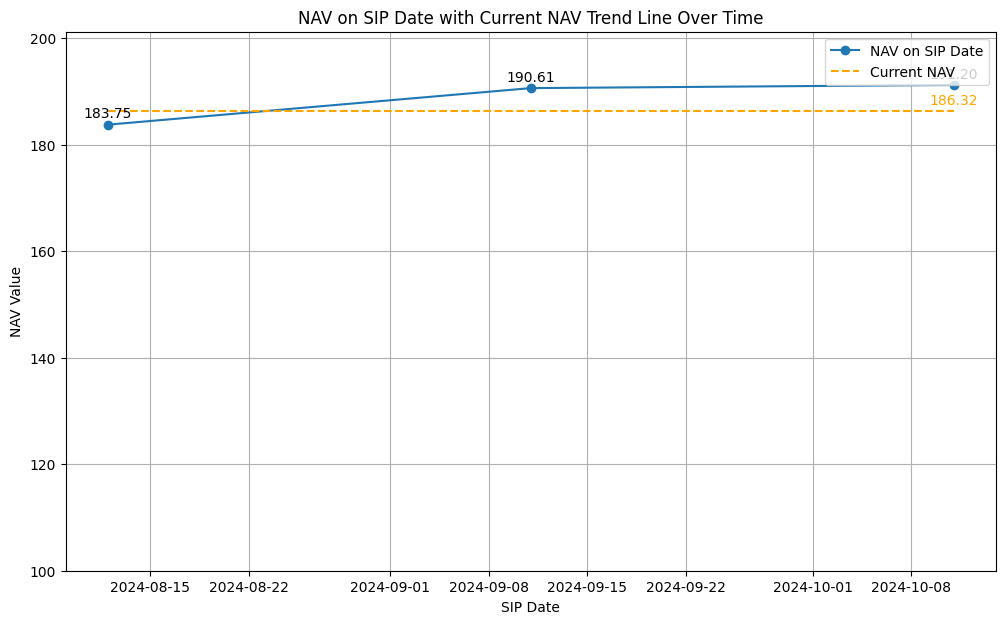

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract only the relevant columns for visualization
limited_df = sip_df[['SIP Date', 'NAV on SIP Date', 'Current NAV']]

# Ensure the 'SIP Date' column is in datetime format
limited_df['SIP Date'] = pd.to_datetime(limited_df['SIP Date'])

# Sort values by 'SIP Date' to ensure the line chart is ordered
limited_df = limited_df.sort_values(by='SIP Date')

# Convert SIP dates to a numeric format for trend line calculation
x_values = np.arange(len(limited_df))  # Numeric representation of dates

# Fit a linear regression trend line for Current NAV
slope, intercept = np.polyfit(x_values, limited_df['Current NAV'], 1)
trend_line = slope * x_values + intercept

# Plotting the line chart
plt.figure(figsize=(12, 7))

# Plot NAV on SIP Date with labels
plt.plot(limited_df['SIP Date'], limited_df['NAV on SIP Date'], label='NAV on SIP Date', marker='o')
for i, txt in enumerate(limited_df['NAV on SIP Date']):
    plt.annotate(f"{txt:.2f}", (limited_df['SIP Date'].iloc[i], limited_df['NAV on SIP Date'].iloc[i]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Plot Current NAV as a trend line
plt.plot(limited_df['SIP Date'], trend_line, label='Current NAV', color='orange', linestyle='--')

# Annotate Current NAV value only at the end of the trend line
current_nav_value = limited_df['Current NAV'].iloc[-1]
plt.annotate(f"{current_nav_value:.2f}",
             (limited_df['SIP Date'].iloc[-1], trend_line[-1]),
             textcoords="offset points", xytext=(0, 5), ha='center', color='orange')

# Set Y-axis limits
plt.ylim(bottom=100, top=max(max(limited_df['NAV on SIP Date']), current_nav_value) + 10)

# Adding chart details
plt.title('NAV on SIP Date with Current NAV Trend Line Over Time')
plt.xlabel('SIP Date')
plt.ylabel('NAV Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

<ipython-input-12-a99ed4dbb7af>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_df['SIP Date'] = pd.to_datetime(limited_df['SIP Date'])


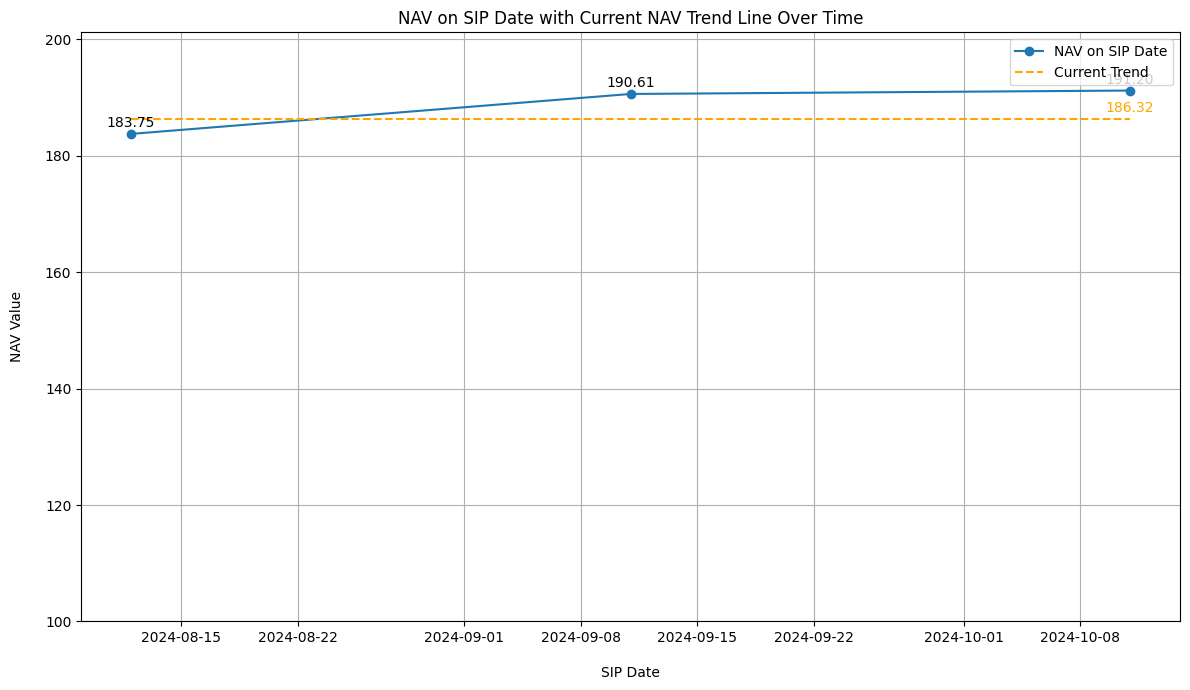

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract only the relevant columns for visualization
limited_df = sip_df[['SIP Date', 'NAV on SIP Date', 'Current NAV']]

# Ensure the 'SIP Date' column is in datetime format
limited_df['SIP Date'] = pd.to_datetime(limited_df['SIP Date'])

# Sort values by 'SIP Date' to ensure the line chart is ordered
limited_df = limited_df.sort_values(by='SIP Date')

# Convert SIP dates to a numeric format for trend line calculation
x_values = np.arange(len(limited_df))  # Numeric representation of dates

# Fit a linear regression trend line for Current NAV
slope, intercept = np.polyfit(x_values, limited_df['Current NAV'], 1)
trend_line = slope * x_values + intercept

# Plotting the line chart
plt.figure(figsize=(12, 7))

# Plot NAV on SIP Date with labels
plt.plot(limited_df['SIP Date'], limited_df['NAV on SIP Date'], label='NAV on SIP Date', marker='o')
for i, txt in enumerate(limited_df['NAV on SIP Date']):
    plt.annotate(f"{txt:.2f}", (limited_df['SIP Date'].iloc[i], limited_df['NAV on SIP Date'].iloc[i]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Plot Current NAV as a trend line
plt.plot(limited_df['SIP Date'], trend_line, label='Current Trend', color='orange', linestyle='--')

# Annotate Current NAV value only at the end of the trend line
current_nav_value = limited_df['Current NAV'].iloc[-1]
plt.annotate(f"{current_nav_value:.2f}",
             (limited_df['SIP Date'].iloc[-1], trend_line[-1]),
             textcoords="offset points", xytext=(0, 5), ha='center', color='orange')

# Set Y-axis limits
plt.ylim(bottom=100, top=max(max(limited_df['NAV on SIP Date']), current_nav_value) + 10)

# Adding chart details
plt.title('NAV on SIP Date with Current NAV Trend Line Over Time')
plt.xlabel('SIP Date', labelpad=15)  # Increase label padding
plt.ylabel('NAV Value', labelpad=15)  # Increase label padding
plt.legend()
plt.grid(True)

# Adjust layout to ensure labels are not cut off
plt.tight_layout()

# Show plot
plt.show()
